## Feature ranking with elimination

In [8]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor



def get_scoring_funtion_polarity(scoring):
    polarity = {
        "explained_variance": True,
        "max_error": False,
        "neg_mean_absolute_error": False,
        "neg_mean_squared_error": False,
        "neg_root_mean_squared_error": False,
        "neg_mean_squared_log_error": False,
        "neg_median_absolute_error": False,
        "r2": True,
        "neg_mean_poisson_deviance": False,
        "neg_mean_gamma_deviance": False,
        "neg_mean_absolute_percentage_error": False
    }

    return polarity[scoring]

def get_score_without_feature(X, y, features_to_drop, scoring, model,n_splits=3):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=3)
    cv_scores = cross_val_score(model, X.drop(features_to_drop, axis=1).values, y.values, cv=kf, scoring=scoring, n_jobs=-1)
    mean_score = np.mean(cv_scores)
    return mean_score


def find_least_important_feature(X, y, scoring, model, n_splits):
    is_polarity_positive = get_scoring_funtion_polarity(scoring)
    intermediate_results = {}
    for featureindex, feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X, y, feature_name, scoring, model, n_splits)
        intermediate_results[feature_name] = score_without_feature
        print("Getting score for: ", feature_name, score_without_feature)

    # calculate the results        
    if is_polarity_positive:
        lowest_feature = None
        lowest_score = -99999
        for feature_name in intermediate_results.keys():
            score_without_feature = intermediate_results[feature_name]
            if score_without_feature >= lowest_score:
                lowest_score = score_without_feature
                lowest_feature = feature_name
            del score_without_feature
    else:
        lowest_feature = None
        lowest_score = 99999
        for feature_name in intermediate_results.keys():
            score_without_feature = intermediate_results[feature_name]
            if score_without_feature <= lowest_score:
                lowest_score = score_without_feature
                lowest_feature = feature_name
            del score_without_feature

    results = {}
    results["lowest_score"] = lowest_score
    results["lowest_feature"] = lowest_feature
    results["intermediate_results"] = intermediate_results
    del intermediate_results
    del lowest_feature
    del lowest_score
    return results

def feature_ranking_elimination(X, y, min_features_required, scoring, model, n_splits):
    results = {}
    current_total_feature = X.shape[1]

    count = 1
    results[current_total_feature] = find_least_important_feature(X, y, scoring, model, n_splits)
    print("lowest feature drop: ",results[current_total_feature]["lowest_feature"])
    current_X = X.drop(results[current_total_feature]["lowest_feature"], axis=1)
    current_total_feature = current_X.shape[1]

    count = count + 1
    while (current_total_feature > min_features_required):
        print("Staring experiment for: ", current_total_feature)
        results[current_total_feature] = find_least_important_feature(current_X, y, scoring, model, n_splits)
        print("Results of ", str(count), " iteration:", results[current_total_feature]["lowest_score"])
        print("lowest feature drop: ",results[current_total_feature]["lowest_feature"])
        current_X = current_X.drop(results[current_total_feature]["lowest_feature"], axis=1)
        current_total_feature = current_X.shape[1]
        count = count + 1

    return results


## Recursive feature elimination with cross-validation


In [1]:
from pathlib import Path
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
import numpy as np

input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
    Path("../data/max_abs_df.csv")
]


input_file = input_files[2]
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]


Input file:  ../data/quantile_df.csv


In [4]:
dff = df[:2000]
y = dff['target']
X = dff.drop("target",axis=1)

Scoring funtion:  r2
Getting score for:  slope_fill2 0.879716734493854
Getting score for:  Thorium_2016 0.8777381054485502
Getting score for:  Clim_Prescott_LindaGregory 0.8806662171104819
Getting score for:  be-30y-85m-avg-GREEN.filled.lzw.nodata 0.8809690923760486
Getting score for:  mrvbf_9 0.8768051950213146
Getting score for:  be-30y-85m-avg-SWIR1.filled.lzw.nodata 0.8795563268850755
Getting score for:  clim_WDA_albers 0.8782396905242105
Getting score for:  be-30y-85m-avg-RED.filled.lzw.nodata 0.8808923585008884
Getting score for:  si_geol1 0.8814602144991414
Getting score for:  relief_mrvbf_3s_mosaic 0.878736357534708
Getting score for:  be-l8-all-85m-avg-NIR.filled.lzw.nodata 0.8801166961113337
Getting score for:  Grav_lane_clip 0.8741292389950107
Getting score for:  tpi_300 0.8783113479543018
Getting score for:  be-30y-85m-avg_BLUE+SWIR2 0.8794955932157033
Getting score for:  ceno_euc_aust1 0.8787433817844192
Getting score for:  relief_roughness 0.8788990155420321
Getting score

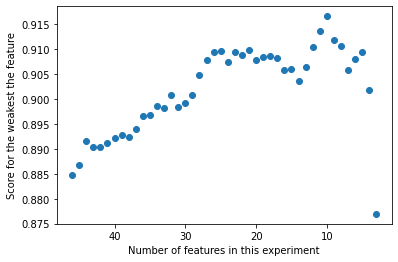

In [9]:
min_features_required=2
model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=3

scorings = ["r2"]

for scoring in scorings:
    print("Scoring funtion: ",scoring)
    results = feature_ranking_elimination(X,y, min_features_required, scoring, model, n_splits)
    
    output_file_name = str(input_file.stem)+"_scorings"+"_1feb.pkl"
    file = open(output_file_name, 'wb')
    pickle.dump(results, file)
    file.close()


    plot_1_data = []
    for exp_no in results.keys():
            plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

    plt.scatter(*zip(*plot_1_data))
    plt.gca().invert_xaxis()
    # plt.ylim(0,0.5)
    plt.xlabel("Number of features in this experiment")
    plt.ylabel("Score for the weakest the feature")
    plt.show()

In [ ]:
from pathlib import Path
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
import numpy as np

input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
    Path("../data/max_abs_df.csv")
]


input_file = input_files[2]
print("Input file: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target']
X = df.drop("target",axis=1)


min_features_required=2
model=XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
n_splits=3

scorings = ["neg_root_mean_squared_error"]

for scoring in scorings:
    print("Scoring funtion: ",scoring)
    results = utl.feature_ranking_elimination(X,y, min_features_required, scoring, model, n_splits)
    
    output_file_name = str(input_file.stem)+"_scorings"+"_1feb.pkl"
    file = open(output_file_name, 'wb')
    pickle.dump(results, file)
    file.close()


    plot_1_data = []
    for exp_no in results.keys():
            plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

    plt.scatter(*zip(*plot_1_data))
    plt.gca().invert_xaxis()
    # plt.ylim(0,0.5)
    plt.xlabel("Number of features in this experiment")
    plt.ylabel("Score for the weakest the feature")
    plt.show()

Input file:  ../data/quantile_df.csv
Scoring funtion:  neg_root_mean_squared_error
Getting score for:  tpi_300 -0.13739939530690512
Getting score for:  Grav_lane_clip -0.1381209840377172
Getting score for:  clim_PTA_albers -0.13805154462655386
Getting score for:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata -0.13764223456382751
Getting score for:  be-30y-85m-avg_BLUE+SWIR2 -0.13781333963076273
Getting score for:  3dem_mag1_fin -0.13858643174171448
Getting score for:  ceno_euc_aust1 -0.13864854474862418
Getting score for:  be-l8-all-85m-avg-BLUE.filled.lzw.nodata -0.13765077789624533
Getting score for:  be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata -0.13774276276429495
Getting score for:  Thorium_2016 -0.1378012498219808
Getting score for:  dem_fill -0.13893455266952515
Getting score for:  relief_elev_focalrange1000m_3s -0.13766202827294668
Getting score for:  LATITUDE_GRID1_clip -0.1379438191652298
Getting score for:  LOC_distance_to_coast -0.1386656016111374
Getting score for:  be-30y

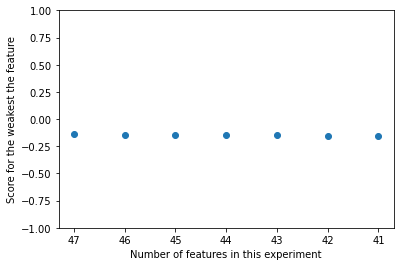

In [13]:
from matplotlib import pyplot as plt
plot_1_data = []
for exp_no in results.keys():
        plot_1_data.append((exp_no,results[exp_no]["lowest_score"]))

plt.scatter(*zip(*plot_1_data))

plt.gca().invert_xaxis()
plt.ylim(-1,1)
plt.xlabel("Number of features in this experiment")
plt.ylabel("Score for the weakest the feature")
plt.show()

In [10]:
output = ""
for k in results:
    output =  results[k]["lowest_feature"] + "\n" + output
print(output)

dem_fill
Potassium_2016
be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata
3dem_mag1_fin
LOC_distance_to_coast
ceno_euc_aust1
Grav_lane_clip
3dem_mag2
LATITUDE_GRID1_clip
clim_WDA_albers
si_geol1
mrvbf_9
relief_elev_focalrange1000m_3s
Rad2016K_Th
Dose_2016
be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
clim_EPA_albers
3dem_mag0.fin
be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata
saga_wetSM_85_reprojected
water-85m_3
s2-dpca-85m_1
clim_RSM_albers
Thorium_2016
clim_PTA_albers
be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata
relief_elev_focalrange300m_3s
water-85m_2
Rad2016U_Th
s2-dpca-85m_2
be-30y-85m-avg-SWIR1.filled.lzw.nodata
relief_mrvbf_3s_mosaic
be-30y-85m-avg-GREEN.filled.lzw.nodata
national_Wii_RF_multirandomforest_prediction
be-30y-85m-avg-RED.filled.lzw.nodata
be-l8-all-85m-avg-NIR.filled.lzw.nodata
slope_fill2
be-30y-85m-avg_BLUE+SWIR2
be-l8-all-85m-avg-BLUE.filled.lzw.nodata
s2-dpca-85m_3
be-30y-85m-avg-SWIR2.filled.lzw.nodata
water-85m_1
relief_roughness
be-30y-85m-avg-CLAY-PC2.filled

# Recursive feature elimination with cross-validation - sklearn

In [2]:
%%time
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from pathlib import Path
import numpy as np
import pandas as pd

input_files = [
    Path("../data/formated_dataset.csv"),
    Path("../data/scaler_df.csv"),
    Path("../data/quantile_df.csv"),
    Path("../data/max_abs_df.csv")    
]     
input_file = input_files[2]
print("Start processing using: ",input_file)
df = pd.read_csv(input_file).astype('float32')
df = df[~df.isin([np.nan, np.inf, -np.inf,-9999.0]).any(1)]
y = df['target'].values
X = df.drop("target",axis=1).values

model = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist', gpu_id=0, n_jobs=-1)
# rfecv = RFECV(estimator=model,min_features_to_select=4)
rfecv = RFECV(estimator=model)

pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])

cv = KFold(n_splits=3,shuffle=True, random_state=3)    
cv_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, verbose=2)
pipeline.fit(X,y)


mean_score = np.mean(cv_scores)
print("cv_scores: ", cv_scores)
# summarize all features
X = df.drop("target",axis=1)
for i in range(X.shape[1]):
    print("Feature Name: ",X.columns.values[i])
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

print('Optimal number of features : %d' % rfecv.n_features_)
print("Grid Scores: ", rfecv.grid_scores_)


Start processing using:  ../data/quantile_df.csv


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  9.1min finished


cv_scores:  [0.77159396 0.76980071 0.77331537]
Feature Name:  tpi_300
Column: 0, Selected False, Rank: 5.000
Feature Name:  Grav_lane_clip
Column: 1, Selected False, Rank: 13.000
Feature Name:  clim_PTA_albers
Column: 2, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata
Column: 3, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg_BLUE+SWIR2
Column: 4, Selected False, Rank: 20.000
Feature Name:  3dem_mag1_fin
Column: 5, Selected True, Rank: 1.000
Feature Name:  ceno_euc_aust1
Column: 6, Selected True, Rank: 1.000
Feature Name:  be-l8-all-85m-avg-BLUE.filled.lzw.nodata
Column: 7, Selected True, Rank: 1.000
Feature Name:  be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata
Column: 8, Selected False, Rank: 14.000
Feature Name:  Thorium_2016
Column: 9, Selected False, Rank: 11.000
Feature Name:  dem_fill
Column: 10, Selected True, Rank: 1.000
Feature Name:  relief_elev_focalrange1000m_3s
Column: 11, Selected True, Rank: 1.000
Feature Name:  LATITUDE_GRI

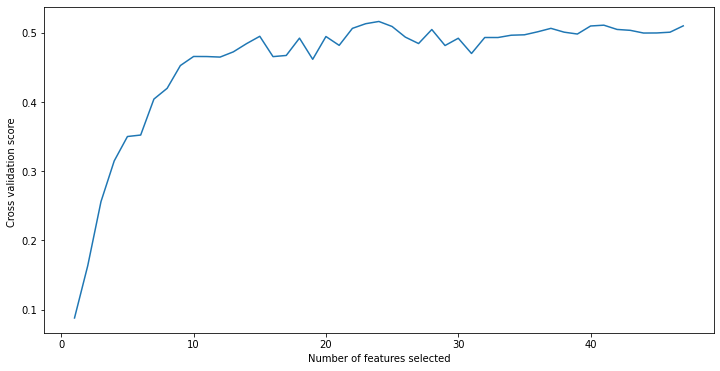

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score ')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [4]:
rfecv.estimator_  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [5]:
data_1_itration = {}
for i,ranking in enumerate(rfecv.ranking_):
    data_1_itration[X.columns.values[i]]=ranking
    

sorted_data_1_itration = {k: v for k, v in sorted(data_1_itration.items(), key=lambda item: item[1])}
for k in sorted_data_1_itration:
    print(k, data_1_itration[k])

clim_PTA_albers 1
be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata 1
3dem_mag1_fin 1
ceno_euc_aust1 1
be-l8-all-85m-avg-BLUE.filled.lzw.nodata 1
dem_fill 1
relief_elev_focalrange1000m_3s 1
LATITUDE_GRID1_clip 1
LOC_distance_to_coast 1
be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata 1
relief_roughness 1
LONGITUDE_GRID1_clip 1
si_geol1 1
3dem_mag2 1
Dose_2016 1
Clim_Prescott_LindaGregory 1
Potassium_2016 1
mrvbf_9 1
Rad2016K_Th 1
be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata 1
clim_RSM_albers 1
relief_elev_focalrange300m_3s 1
relief_mrvbf_3s_mosaic 1
saga_wetSM_85_reprojected 1
national_Wii_RF_multirandomforest_prediction 2
water-85m_3 3
Rad2016U_Th 4
tpi_300 5
clim_WDA_albers 6
s2-dpca-85m_1 7
be-30y-85m-avg-SWIR2.filled.lzw.nodata 8
water-85m_2 9
be-30y-85m-avg-SWIR1.filled.lzw.nodata 10
Thorium_2016 11
clim_EPA_albers 12
Grav_lane_clip 13
be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata 14
3dem_mag0.fin 15
water-85m_1 16
be-30y-85m-avg-RED.filled.lzw.nodata 17
s2-dpca-85m_2 18
be-30y-85m-avg